In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import os
from IPython.display import display

Nous étudions dans ce notebook le modèle de **regression logistique**.

# 1. Chargement d'une base Sentiment140 préprocessée 

On travaille tout d'abord avec un pré-processing fixé.

In [6]:
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if  NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))

In [7]:
df = df.sample(50000, random_state=1234)
df.head(10)

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [8]:
X = df.text.to_list()
y = df.sentiment.to_list()

# 2. Différentes méthodes de feature extraction
## 2.1. Count Vectorizer
### 2.1.1. Exemple

In [5]:
array = ["Car was cleaned by Jack", 
       "Jack was cleaned by Car", 
       "Hello"]
vectorizer = CountVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

L'encodage de la table `array` par la méthode **Count Vectorizer** est : 

In [6]:
print(X_.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


### 2.1.2. Application de la regression logistique

In [3]:
def conf_matrix(X, y, vectorizer, model, verbose=True):
    X = vectorizer.fit_transform(X).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, train_size=0.80, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
    sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    probs = model.predict_proba(X_test)[:,1]
    
    if verbose:    
        metrics.plot_confusion_matrix(model, X_test, y_test)
        plt.show()

        print(f"Accuracy : {sc_accuracy}")
        print(f"Balanced accuracy : {sc_balanced_accuracy}")
    #     print(f"Recall : {sc_recall}")
    #     print(f"Precision : {sc_precision}")
    #     print(f"F1 : {sc_f1}")
        print(f"ROC AUC : {sc_roc_auc}")
    
    metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}
    
    if not verbose:
        return X_train, X_test, y_train, y_test, probs, metrics_score
    

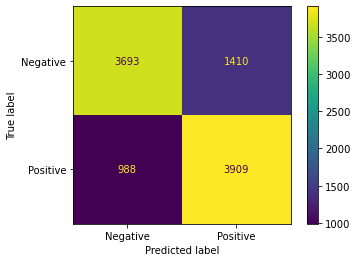

Accuracy : 0.7602
Balanced accuracy : 0.7619232830080874
ROC AUC : 0.8343160703676211


In [8]:
conf_matrix(X, y, CountVectorizer(max_features = 1000), LogisticRegression())

## 2.2. TF-IDF
### 2.2.1. Exemple

In [9]:
array = ["Blue car was cleaned by Jack", 
         "Jack was cleaned by red car", 
         "Hello"]
vectorizer = TfidfVectorizer()
X_ = vectorizer.fit_transform(array)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

L'encodage de la table `array` par la méthode **TD-IDF** est : 

In [10]:
print(X_.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


### 2.2.2. Application de la regression logistique

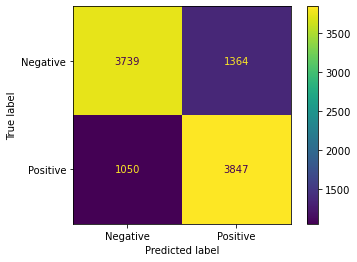

Accuracy : 0.7586
Balanced accuracy : 0.7594967822497015
ROC AUC : 0.8404903704936229


In [11]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000), LogisticRegression())

## 2.3. N-grams

La méthode N-grams peut-être utilisé sur les méthodes **Count Vectorizer** et **TD-IDF**.

### 2.3.1. Exemple

In [12]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(2,2))
X_ = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue car',
 'by jack',
 'by red',
 'car was',
 'cleaned by',
 'jack was',
 'red car',
 'was cleaned']

L'encodage de la table `array` par les méthodes **Count Vectorizer et N-grams** est : 

In [13]:
print(X_.toarray())

[[1 1 0 1 1 0 0 1]
 [0 0 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0]]


### 2.3.2. Application de la regression logistique

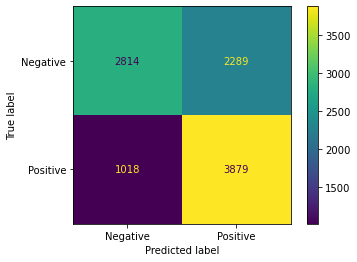

Accuracy : 0.6693
Balanced accuracy : 0.681616715270952
ROC AUC : 0.745171300893247


In [14]:
conf_matrix(X, y, CountVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression(max_iter=200))

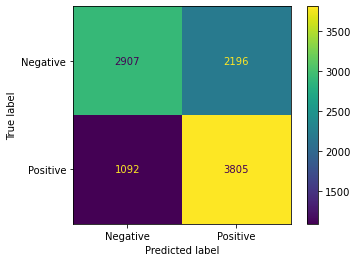

Accuracy : 0.6712
Balanced accuracy : 0.6804963613841304
ROC AUC : 0.7472049438899891


In [15]:
conf_matrix(X, y, TfidfVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression(max_iter=200))

# 3. Comparaisons des méthodes de feature extraction

L'objectif est de comparer les 3 méthodes de feature extraction **Count Vectorizer**, **TD-IDF** et **N-grams**, en faisant ensuite varier la méthode de pré-processing et le nombre de features.
Nous pourrons alors en déduire la combinaison optimale pour la **regression logistique**.

## 3.1. Comparaison des méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé

On compare les méthodes de feature extraction à pré-processing fixé et avec un nombre de features fixé pour l'instant.

In [4]:
def comparaison(X, y, N, show_graph=True, show_table=True):
    """
    N correspond au nombre de features
    """
    table = []

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr,tpr,":", label=f"CountVectorizer {N} ngram 2")
    table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N} ngram 2")
    table.append(metrics_score)
    
    if show_graph:
        plt.plot([0, 1], [0, 1], "r-")
        plt.plot([0, 0, 1], [0, 1, 1], 'b-')
        plt.legend()
        plt.show()

    if show_table:
        display(pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"]))

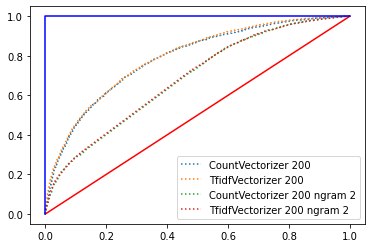

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 200,0.7114,0.714251,0.786835
TfidfVectorizer 200,0.7150,0.716304,0.792120
CountVectorizer 200 ngram 2,0.6195,0.636330,0.682787
TfidfVectorizer 200 ngram 2,0.6195,0.633657,0.684976


Wall time: 7.01 s


In [17]:
%%time
comparaison(X, y, 200)

**Conclusion :** Le modèle de feature extraction le plus performant (pour la méthode de pré-processing fixée et le nombre de features fixé) est ici le `TfidfVectorizer`. L'ajout de la fonction ngram demande en fait d'augmenter le nombre de features (de $n$ à $n^2$), ce qui demande plus de temps de calcul : 

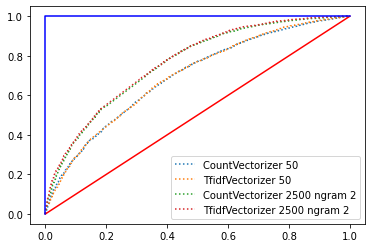

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 50,0.6399,0.644701,0.694696
TfidfVectorizer 50,0.6415,0.643489,0.695593
CountVectorizer 2500 ngram 2,0.6872,0.694909,0.761733
TfidfVectorizer 2500 ngram 2,0.6882,0.693659,0.767187


In [18]:
table = []

N = 50

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N}")
table.append(metrics_score)

_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N}")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"CountVectorizer {N**2} ngram 2")
table.append(metrics_score)


_, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N**2, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
plt.plot(fpr,tpr,":", label=f"TfidfVectorizer {N**2} ngram 2")
table.append(metrics_score)

plt.plot([0, 1], [0, 1], "r-")
plt.plot([0, 0, 1], [0, 1, 1], 'b-')

plt.legend()
plt.show()

pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N**2} ngram 2", f"TfidfVectorizer {N**2} ngram 2"])

On peut voir qu'en prenant $n$ et $n^2$, les courbes se rapprochent un peu, mais il faudrait encore augmenter le nombre de features pour les méthodes ngram pour égaler les méthodes non ngram.

## 3.2. Influence des méthodes de pré-processing
Nous faisons à présent varier les méthodes de pré-processing :

In [19]:
%%time
for stop_words in [False, True]:
#     for lemmatization in [False, True]:
    for lemmatization in [False]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
            X = df.text.to_list()
            y = df.sentiment.to_list()
            comparaison(X, y, 200, show_graph=False)

stop_words: False, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 200,0.712925,0.714323,0.784336
TfidfVectorizer 200,0.714165,0.714467,0.789357
CountVectorizer 200 ngram 2,0.625847,0.641584,0.682372
TfidfVectorizer 200 ngram 2,0.625669,0.639135,0.682348


stop_words: False, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 200,0.699516,0.699850,0.770303
TfidfVectorizer 200,0.699644,0.699718,0.775031
CountVectorizer 200 ngram 2,0.598206,0.613923,0.658120
TfidfVectorizer 200 ngram 2,0.598992,0.614147,0.657765


stop_words: True, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 200,0.704626,0.709043,0.780485
TfidfVectorizer 200,0.703803,0.706481,0.780579
CountVectorizer 200 ngram 2,0.579802,0.646439,0.610293
TfidfVectorizer 200 ngram 2,0.580009,0.644931,0.610074


stop_words: True, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 200,0.677937,0.682801,0.759947
TfidfVectorizer 200,0.682198,0.683923,0.761562
CountVectorizer 200 ngram 2,0.539184,0.623152,0.574399
TfidfVectorizer 200 ngram 2,0.539109,0.621663,0.574278


Wall time: 14min 32s


La combinaison optimale, pour le nombre de features fixé, correspond ici au pré-processing `stop_words: False, lemmatization: False, negation: False` combiné à la méthode de feature extraction **TF-IDF**. 

Toutes choses égales par ailleurs, la suppression des stop-words (`stop_words: True`) ne semble généralement pas bénéfique.

## 3.3. Influence du nombre de features
Nous faisons à présent varier le nombre de features.

### 3.3.1. Exemple avec une méthode de pré-processing fixé et TfidfVectorizer

array([  100.        ,   166.81005372,   278.25594022,   464.15888336,
         774.26368268,  1291.54966501,  2154.43469003,  3593.8136638 ,
        5994.84250319, 10000.        ])

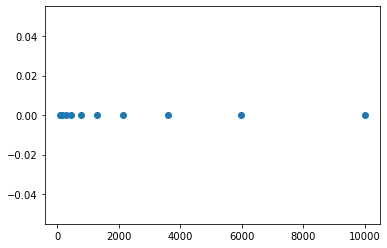

In [20]:
N = 10
plt.plot(np.logspace(2, 4, N, endpoint=True), np.zeros(N), 'o')
np.logspace(2, 4, N, endpoint=True)

In [11]:
%%time
N = 10
max_features_list = np.logspace(2, 3.8, N, endpoint=True, dtype=int)   # De 10^2 à 10^3.8
table = []
for max_features in max_features_list:
    _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
    table.append(metrics_score)
df = pd.DataFrame(table, index=max_features_list)

Wall time: 1min 26s


[]

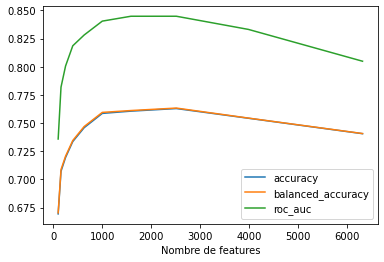

In [12]:
for i in df.columns:
    df[i].plot(label=i)

plt.legend()
plt.xlabel("Nombre de features")
plt.plot()

### 3.3.2 Pré-processing fixé et variation des méthodes de feature extraction

On garde le pré-processing fixé et on fait varier les méthodes de feature extraction.

In [ ]:
def influence_features(X, y, N):
    max_features_list = np.logspace(2, 3, N, endpoint=True, dtype=int)   # De 10^2 à 10^3.8
    table = []
    for max_features in max_features_list:
        _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['model'] = "CountVectorizer"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['model'] = "TfidfVectorizer"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = max_features, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['model'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = max_features, ngram_range=(2,2)), LogisticRegression(max_iter=200), verbose=False)
        metrics_score['features'] = max_features
        metrics_score['model'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    models = list(set(df.model))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1,len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_model in range(len(models)):
            df[df.model == models[j_model]].plot(x='features', y=scores[i_score], label=models[j_model], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.plot()
    return df

In [ ]:
%%time
df_metrics = influence_features(X, y, 3)

In [ ]:
df_metrics

### 3.3.3. Variations du pré-processing et des méthodes de feature extraction

Nous faisons à présent tout varier (pré-processing, feature extraction).

In [ ]:
%%time
for stop_words in [False, True]:
#     for lemmatization in [False, True]:
    for lemmatization in [False]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))
            X = df.text.to_list()
            y = df.sentiment.to_list()
            df_metrics = influence_features(X, y, 3)
            df_metrics['stop_words'] = stop_words
            df_metrics['lemmatization'] = lemmatization
            df_metrics['negation'] = negation

In [ ]:
df_metrics